# Alternative loss function vs MSE

Define function to interpolate for

In [1]:
import torch
from torch import Tensor
def fn_interpolate(x: Tensor):
    return torch.exp(x)

Sample points to work with

In [2]:
N = 5
x = torch.linspace(0, 2, N)
y = fn_interpolate(x)
eps = 0.5

## Work with alternative loss function

Define ''alternative'' loss function

In [6]:
def alternative_loss(A: Tensor, lda: Tensor, f: Tensor) -> Tensor:
    return (1 / 2) * lda.t() @ A @ lda - lda.t() @ f

Create matrix `A` using previous code, as well as vectors `lda`, `f`

In [7]:
import sys
sys.path.insert(0, '..')

from rbf_interpolator import get_rbf_matrix

# Define problem paramenters
A = torch.from_numpy(get_rbf_matrix(x, x, eps)).float()
f = y
lda = torch.nn.Parameter(data = torch.randn(N))

# Preemptively calculate solution by matrix inversion
lda_optimum = torch.linalg.solve(A, f)

Find optimum values for `lda` and store them in `parameters_progress` auxiliary array

In [19]:
max_iterations = 120000
parameters_progress = torch.zeros(size=(max_iterations, N))

optimizer = torch.optim.Adam(params=[lda], lr=1e-2)
for i in range(max_iterations):
    loss = alternative_loss(A, lda, f)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    parameters_progress[i, :] = lda
    print(f'{i}: {loss.item()}', end='\r')

Plot approach towards the exact parameters

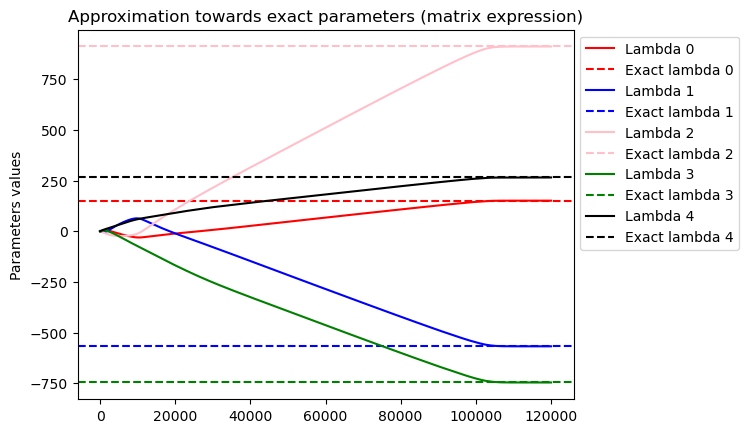

In [23]:
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'pink', 'green', 'black']

for i in range(5):
    plt.plot(parameters_progress[:, i].detach().numpy(), label=f"Lambda {i}", color = colors[i])
    plt.axhline(lda_optimum[i], color = colors[i], linestyle='dashed', label=f'Exact lambda {i}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Parameter values')
plt.xlabel('Iterations')
plt.title('Approximation towards exact parameters (matrix expression)')
plt.show()

## Work with MSE loss function

In [3]:
import sys
sys.path.insert(0, '..')

import nn_rbf
import torch

# Use estimation of starting parameters
nn_interpolator = nn_rbf.RBFInterpolant(x, eps, alphas=[120., -500., 800., -750., 250.]) 

Train model with MSE

In [4]:
max_iterations = 200000
parameters_progress_mse = torch.zeros(size=(max_iterations, N), requires_grad = False)

# mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=nn_interpolator.parameters(), lr=1e-2)
for i in range(max_iterations):
    loss = torch.sum((nn_interpolator(x) - y) ** 2) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    parameters_progress_mse[i, :] = nn_interpolator.alphas
    print(f'{i}: {loss.item()}', end='\r')

Print computed parameters vs parameters by matrix inversion

In [8]:
print(nn_interpolator.alphas)
print(lda_optimum)

Parameter containing:
tensor([ 134.3389, -510.8537,  831.8885, -689.5457,  248.9364],
       requires_grad=True)
tensor([ 151.1364, -567.4019,  911.8722, -745.8817,  265.6092])


Represent approximation to the exact parameters

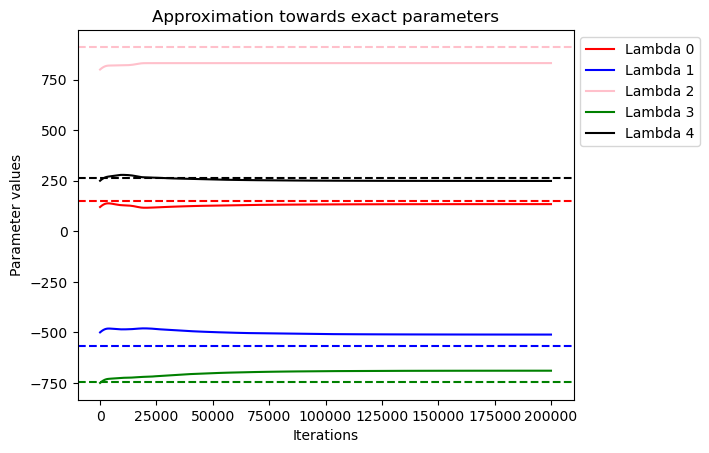

In [9]:
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'pink', 'green', 'black']

for i in range(5):
    plt.plot(parameters_progress_mse[:, i].detach().numpy(), label=f"Lambda {i}", color = colors[i])
    plt.axhline(lda_optimum[i], color = colors[i], linestyle='dashed')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Approximation towards exact parameters')
plt.ylabel('Parameter values')
plt.xlabel('Iterations')
plt.show()